In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
folder = 'drive/MyDrive/Code/GitHub/CellularAutomata'
import sys
sys.path.insert(1, folder)
import ca_model
import count_pixels_dataset as cpd
import visualisation as vis_ca
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2480324254259306170
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9597028825066737161
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
# import importlib
# importlib.reload(ca_model)
# importlib.reload(vis_ca)

In [4]:
# Type of Run
JustTestingCode = False # If True run everything faster, for Debugging
FullModelQ = True # If True, then the model has many parameters. Use False if you want to overfit and only use 2 classes

seed_training = 1
seed_movies = 1

LoadPreviousModelQ = False # if True we load the model, either for further training or just testing
i_step_load = 250
RunTrainingQ = True # If True we run the neural network training

RebuildDatasetQ = False # if True we rebuild the dataset
size_ds = 100000 #the number of images on the dataset

ADD_NOISE = True # if True then the normal update of the CA has noise added
InitializeRandomQ = True # if True, the initial state of the CA is random
MutateTrainingQ = True # if True, during training we mutate the image to anothe random one
MutateTestingQ = True # if True, during testing we mutate the image

RunTestMoviesQ = True # if True, in the end we test an increasing size of inputs
RunTestIncreaseQ = True # if True, in the end we test an increasing size of inputs

no_channels = 'SameClasses' # 'SameClasses' '5PlusClasses' '4TimesClasses'

dataset = 'count_digits'
id_run = 'CA_CD_3Classes_Deeper_M{}_MutTrain{}_MutTest{}_AddNoise{}'.format(no_channels, MutateTrainingQ, MutateTestingQ, ADD_NOISE) # the prefix to all file names which will be use for saving and loading the model

NO_CLASSES = 3
limits_classes = [2, 8] #len of this should be NO_CLASSES-1
MAXPIXELS = 15
BOUNDARY_P = 0.4
limits_c_p = [0] + limits_classes + [MAXPIXELS]
color_lookup = tf.constant([
                    [255, 0, 0],
                    [0, 255, 0],
                    [0, 0, 255],
                    [0, 0, 0], # This is the default for digits.
                    [255, 255, 255] # This is the background.
                    ])

H, W = 10, 10

TR_EVOLVE = 50 # Number of time steps to let CA evolve for each input during training
TST_EVOLVE = 50 # Number of time steps to let CA evolve for each input during testing

BATCH_SIZE = 64 # number of images per batch

if no_channels == 'SameClasses':
    NO_CHANNELS = NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '4TimesClasses':
    NO_CHANNELS = 4 * NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '5PlusClasses':
    NO_CHANNELS = 5 + NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
    
if JustTestingCode:
    TR_NO_ITERATIONS = 500 # number of iterations for the training loop
    export_every = 250 # number of iterations between each model export
    visualise_every = 50 # number of iteration between each model visualisation
    i_step_verify = [500] # [250, 500]
else:
    TR_NO_ITERATIONS = 500000 # number of iterations for the training loop
    export_every = 10000 # number of iterations between each model export
    visualise_every = 2000 # number of iteration between each model visualisation
    i_step_verify = [240000, 500000] # [240000, 500000]

    # TR_NO_ITERATIONS = 5000 # number of iterations for the training loop
    # export_every = 1000 # number of iterations between each model export
    # visualise_every = 500 # number of iteration between each model visualisation
    # i_step_verify = [0, 5000] # [240000, 500000]

    # TR_NO_ITERATIONS = 20000 # number of iterations for the training loop
    # export_every = 1000 # number of iterations between each model export
    # visualise_every = 500 # number of iteration between each model visualisation
    # i_step_verify = [0, 20000] # [240000, 500000]


In [5]:
ca_model.CAModel(NO_CHANNELS, NO_CLASSES, H, W, full_model=FullModelQ).update_state.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 10, 10, 80)           2960      
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 10, 10, 120)          9720      
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 10, 10, 3)            363       
Total params: 13,043
Trainable params: 13,043
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Prepare the dataset
BuildDS = False
if RebuildDatasetQ:
    BuildDS = True
else:
    try:
        res = np.load(folder + '/dataset/{}_NoClasses{}_{}_MaxPixels{}_BoundP{}.npz'.format(dataset, NO_CLASSES, size_ds, MAXPIXELS, int(BOUNDARY_P*100)))
        x_train = res['x_train']
        y_train = res['y_train']
        x_test = res['x_test']
        y_test = res['y_test']
    except:
        BuildDS = True
if BuildDS:
    x_train, x_test, y_train, y_test = cpd.build_dataset(size_ds, H, W, limits_classes, max_pixels=MAXPIXELS, boundary_p=BOUNDARY_P)
    np.savez(folder + '/dataset/{}_NoClasses{}_{}_MaxPixels{}_BoundP{}.npz'.format(dataset, NO_CLASSES, size_ds, MAXPIXELS, int(BOUNDARY_P*100)), x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

y_train_pic = cpd.to_classes_dim_label(x_train, y_train, limits_classes)
y_label_train = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    y_label_train[i] = cpd.class_indice_f(y_train[i], limits_classes)
# y_test_pic = to_classes_dim_label(x_test, y_test)

In [7]:
lr = 1e-3 # initial learning rate
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([int(TR_NO_ITERATIONS*0.3), int(TR_NO_ITERATIONS*0.7)], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
trainer = tf.keras.optimizers.Adam() # use ADAM optimizer

loss_log = np.zeros(TR_NO_ITERATIONS) # for plotting of loss function across time
loss_log_classes = np.zeros((TR_NO_ITERATIONS, NO_CLASSES)) # for plotting of loss function across time

In [8]:
if LoadPreviousModelQ:
    ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_run, i_step_load, NO_CHANNELS, NO_CLASSES, H, W, ADD_NOISE)
    ITER = i_step_load + 1
else:
    ca = ca_model.CAModel(NO_CHANNELS, NO_CLASSES, H, W, add_noise=ADD_NOISE)
    ITER = 0

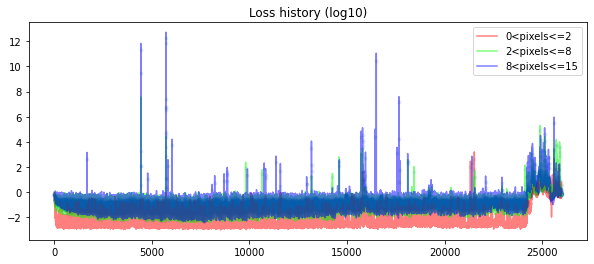

 step: 26991, log10(loss): -1.1079466342926025, log10(loss)[classes]: [-2.1684496 -0.8802179 -1.1444968]

In [ ]:
# Training happens here
np.random.seed(seed_training)
if RunTrainingQ:
    # Training Loop
    for i in range(ITER, TR_NO_ITERATIONS):

        b_idx = np.random.randint(0, x_train.shape[0] - 1, size=BATCH_SIZE)
        if InitializeRandomQ:
            x0 = ca.initialize(x_train[b_idx])
            x0 = ca.initialize_random(x_train[b_idx])
        else:
            x0 = ca.initialize_random(x_train[b_idx])
            x0 = ca.initialize(x_train[b_idx])
        y0 = y_train_pic[b_idx]
        y0_label = y_label_train[b_idx]
        y0_label = tf.convert_to_tensor(y0_label)        

        x, loss, c_l = ca_model.train_step(trainer, ca, x0, y0, y0_label, TR_EVOLVE, NO_CLASSES, MutateTrainingQ=MutateTrainingQ)

        loss_log[i] = loss.numpy()
        loss_log_classes[i, :] = [k.numpy() for k in c_l]

        if i % visualise_every == 0:
            clear_output()
            vis_ca.plot_loss(loss_log[:i], loss_log_classes[:i, :], folder, id_run, limits_c_p, color_lookup, True)
        if i % export_every == 0:
            ca_model.export_model(folder, id_run, ca, i, loss_log, loss_log_classes)

        print('\r step: {}, log10(loss): {}, log10(loss)[classes]: {}'.format(i + 1, np.log10(loss), np.log10(c_l)), end='')
    ca_model.export_model(folder, id_run, ca, TR_NO_ITERATIONS, loss_log, loss_log_classes)

In [ ]:
if RunTestMoviesQ:
    eval_bs = 5 ** 2 # number of samples to show in the movie
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_run, i_step_v, NO_CHANNELS, NO_CLASSES, H, W, ADD_NOISE)

        np.random.seed(seed_movies)

        new_idx = np.random.randint(0, x_test.shape[0] - 1, size=eval_bs)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_test[new_idx])
        else:
            x0 = ca.initialize(x_test[new_idx])

        vis_ca.make_run_videos(folder, id_run, i_step_v, TST_EVOLVE, MutateTestingQ, x, ca, color_lookup)

In [ ]:
if RunTestIncreaseQ:
    eval_bs = 5 ** 2 # number of samples to show in the movie
    max_size = MAXPIXELS

    images = np.zeros((max_size, eval_bs, H, W), dtype=np.float32)
    for i_img in range(eval_bs):
        images[0, i_img, int(H / 2), int(W / 2)] = 1
    for j in range(1, max_size):
        for i_img in range(eval_bs):
            images[j, i_img, :, :] = vis_ca.add_pixel(images[j - 1, i_img, :, :])
    images = tf.constant(images)
    
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_run, i_step_v, NO_CHANNELS, NO_CLASSES, H, W, ADD_NOISE)
        vis_ca.make_videos_increase(folder, id_run, i_step_v, TST_EVOLVE, ca, color_lookup, images, InitializeRandomQ)